# League Position Prediction - Template
**Important: Run cells sequentially from top to bottom (Shift+Enter or Run All). Each cell depends on variables created by previous cells.**

This notebook predicts the final league standings for the Serie A season based on Monte Carlo simulations.

## 1. Setup and Configuration

In [1]:
# Import required libraries
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, "..")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

### Load Configuration

Import the configuration file for your league. Configuration files are stored in the `configs/` directory.

In [2]:
# Load configuration for the league
config_file = "../configs/seriea.yaml"  # Change this to use a different league

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

print(f"League: {config['league']['name']}")
print(f"Country: {config['league']['country']}")
print(f"Season: {config['league']['current_season']}")

League: Serie A
Country: Italy
Season: 2025


## 2. Data Loading and Preparation

Load and prepare match data from the configured sources.

In [3]:
# Import data loading and preprocessing modules
from src.data import (
    load_fixture_csv,
    load_match_statistics,
    normalize_team_names,
    prepare_match_statistics,
)
from src.preprocessing import (
    calculate_home_team_statistics,
    calculate_away_team_statistics,
    calculate_efficiency_metrics,
    calculate_league_table,
)
from src.preprocessing.utils import (
    create_played_matches_dataframe,
    create_remaining_matches_dataframe,
)

# Load fixtures data
fixtures_path = f"../data/raw/{config['data_sources']['all_matches']['filename']}"
fixtures = load_fixture_csv(fixtures_path)

# Normalize team names based on configuration
fixtures = normalize_team_names(fixtures, config.get("team_name_mapping", {}))

print(f"Loaded {len(fixtures)} fixtures")
print(f"Fixtures shape: {fixtures.shape}")
print(f"\nFirst 5 fixtures:")
print(fixtures.head())

Loaded 380 fixtures
Fixtures shape: (380, 7)

First 5 fixtures:
   Match Number  Round Number              Date  \
0             1             1  23/08/2025 16:30   
1             2             1  23/08/2025 16:30   
2             3             1  23/08/2025 18:45   
3             4             1  23/08/2025 18:45   
4             5             1  24/08/2025 16:30   

                              Location Home Team   Away Team Result  
0                       Luigi Ferraris     Genoa       Lecce  0 - 0  
1  Mapei Stadium - Città del Tricolore  Sassuolo      Napoli  0 - 2  
2                             San Siro     Milan   Cremonese  1 - 2  
3                             Olimpico      Roma     Bologna  1 - 0  
4                         Unipol Domus  Cagliari  Fiorentina  1 - 1  


In [4]:
# Load match statistics
stats_path = f"../data/raw/{config['data_sources']['match_statistics']['filename']}"
statistics = load_match_statistics(stats_path)

# Prepare statistics: standardize columns and normalize team names
statistics = prepare_match_statistics(statistics, config)

print(f"Loaded {len(statistics)} match results")
print(f"Statistics shape: {statistics.shape}")
print(f"\nFirst 5 matches:")
print(statistics.head())

Loaded 230 match results
Statistics shape: (230, 10)

First 5 matches:
         Date Home Team   Away Team  Home Goals  Away Goals Result  \
0  23/08/2025     Genoa       Lecce           0           0      D   
1  23/08/2025  Sassuolo      Napoli           0           2      A   
2  23/08/2025     Milan   Cremonese           1           2      A   
3  23/08/2025      Roma     Bologna           1           0      H   
4  24/08/2025  Cagliari  Fiorentina           1           1      D   

   Home Shots  Away Shots  Home Shots on Target  Away Shots on Target  
0           5           7                     2                     0  
1           7          13                     2                     4  
2          24           4                     6                     3  
3          14          10                     4                     2  
4          14           4                     6                     1  


In [5]:
# Separate played and remaining matches
played_matches = create_played_matches_dataframe(statistics)
remaining_matches = create_remaining_matches_dataframe(fixtures)

print(f"Played matches: {len(played_matches)}")
print(f"Remaining matches: {len(remaining_matches)}")
print(f"\nRemaining matches sample:")
print(remaining_matches.head())

Played matches: 230
Remaining matches: 150

Remaining matches sample:
       Home Team Away Team
0  Hellas Verona      Pisa
1          Genoa    Napoli
2     Fiorentina    Torino
3        Bologna     Parma
4          Lecce   Udinese


## 3. Team Statistics Analysis

Calculate statistics for each team in their home and away performances.

In [6]:
# Calculate home and away team statistics
home_stats = calculate_home_team_statistics(statistics)
away_stats = calculate_away_team_statistics(statistics)

# Calculate efficiency metrics
home_stats, away_stats = calculate_efficiency_metrics(home_stats, away_stats)

print("Home Team Statistics (sorted by attacking efficiency):")
print(
    home_stats.sort_values("home_attack_eff", ascending=False)[
        [
            "avg_home_goals_scored",
            "home_attack_eff",
            "home_defense_eff",
            "home_chance_creation_eff",
            "home_chance_suppression_eff",
        ]
    ].head(10)
)

Home Team Statistics (sorted by attacking efficiency):
           avg_home_goals_scored  home_attack_eff  home_defense_eff  \
Home Team                                                             
Inter                   2.750000         0.142857          0.095238   
Cagliari                1.363636         0.141509          0.094203   
Napoli                  1.727273         0.125828          0.069767   
Lazio                   1.500000         0.120805          0.094595   
Juventus                2.090909         0.113861          0.072727   
Cremonese               1.000000         0.113402          0.095541   
Como                    1.666667         0.104712          0.068627   
Sassuolo                1.090909         0.096000          0.099291   
Milan                   1.545455         0.090909          0.091837   
Atalanta                1.500000         0.090000          0.071429   

           home_chance_creation_eff  home_chance_suppression_eff  
Home Team                

In [7]:
print("\nAway Team Statistics (sorted by attacking efficiency):")
print(
    away_stats.sort_values("away_attack_eff", ascending=False)[
        [
            "avg_away_goals_scored",
            "away_attack_eff",
            "away_defense_eff",
            "away_chance_creation_eff",
            "away_chance_suppression_eff",
        ]
    ].head(10)
)


Away Team Statistics (sorted by attacking efficiency):
           avg_away_goals_scored  away_attack_eff  away_defense_eff  \
Away Team                                                             
Milan                   1.750000         0.166667          0.050000   
Bologna                 1.666667         0.153846          0.111842   
Pisa                    1.454545         0.146789          0.122642   
Genoa                   1.363636         0.122951          0.108571   
Como                    1.545455         0.118056          0.071429   
Udinese                 1.272727         0.117647          0.114650   
Sassuolo                1.250000         0.112782          0.083333   
Inter                   1.727273         0.101064          0.102273   
Cagliari                1.083333         0.100775          0.105882   
Atalanta                1.090909         0.096000          0.076389   

           away_chance_creation_eff  away_chance_suppression_eff  
Away Team               

## 4. Current League Table

Show the current league standings before simulation.

In [8]:
# Calculate current league table
current_league_table = calculate_league_table(played_matches)

print(
    f"Current League Table (after {current_league_table['Played'].head(1).values[0]} matches played):\n"
)
print(
    current_league_table[
        [
            "Position",
            "Team",
            "Played",
            "Wins",
            "Draws",
            "Losses",
            "Goals For",
            "Goals Against",
            "Goal Difference",
            "Points",
        ]
    ].to_string(index=False)
)

Current League Table (after 23 matches played):

 Position          Team  Played  Wins  Draws  Losses  Goals For  Goals Against  Goal Difference  Points
        1         Inter      23    18      1       4         52             19               33      55
        2         Milan      23    14      8       1         38             17               21      50
        3        Napoli      23    14      4       5         33             21               12      46
        4      Juventus      23    13      6       4         39             18               21      45
        5          Roma      23    14      1       8         27             14               13      43
        6          Como      23    11      8       4         37             16               21      41
        7      Atalanta      23     9      9       5         30             20               10      36
        8         Lazio      23     8      8       7         24             21                3      32
        9      

## 5. Monte Carlo Simulation

Run Monte Carlo simulations to predict final league table positions.

In [9]:
# Import Monte Carlo simulation functions
from src.modelling import (
    monte_carlo_simulation,
    calculate_position_probabilities,
    get_team_final_position_stats,
)

# Run Monte Carlo simulation
n_simulations = config["simulation"]["n_simulations"]
random_seed = config["simulation"]["random_seed"]

print(f"Running {n_simulations} Monte Carlo simulations...")

league_tables_sim, full_season_results_sim = monte_carlo_simulation(
    fixtures,
    played_matches,
    home_stats,
    away_stats,
    n_simulations=n_simulations,
    random_seed=random_seed,
)

print(f"Completed {len(league_tables_sim)} simulations")

Running 1000 Monte Carlo simulations...
Completed 1000 simulations


In [10]:
# Calculate position probabilities
position_probs = calculate_position_probabilities(
    league_tables_sim, current_league_table
)

print("\nFinal Position Probabilities:")
print(position_probs)


Final Position Probabilities:
                  1      2      3      4      5      6      7      8      9   \
Inter          0.927  0.072  0.001  0.000  0.000  0.000  0.000  0.000  0.000   
Milan          0.066  0.651  0.205  0.065  0.012  0.001  0.000  0.000  0.000   
Napoli         0.002  0.102  0.305  0.342  0.167  0.078  0.004  0.000  0.000   
Juventus       0.005  0.144  0.360  0.275  0.165  0.049  0.002  0.000  0.000   
Roma           0.000  0.009  0.067  0.176  0.363  0.336  0.049  0.000  0.000   
Como           0.000  0.022  0.061  0.137  0.273  0.452  0.055  0.000  0.000   
Atalanta       0.000  0.000  0.001  0.005  0.019  0.078  0.703  0.145  0.040   
Lazio          0.000  0.000  0.000  0.000  0.001  0.004  0.096  0.390  0.242   
Udinese        0.000  0.000  0.000  0.000  0.000  0.002  0.037  0.181  0.262   
Bologna        0.000  0.000  0.000  0.000  0.000  0.000  0.040  0.159  0.234   
Sassuolo       0.000  0.000  0.000  0.000  0.000  0.000  0.008  0.086  0.120   
Cagliari 

## 6. Visualization of Results

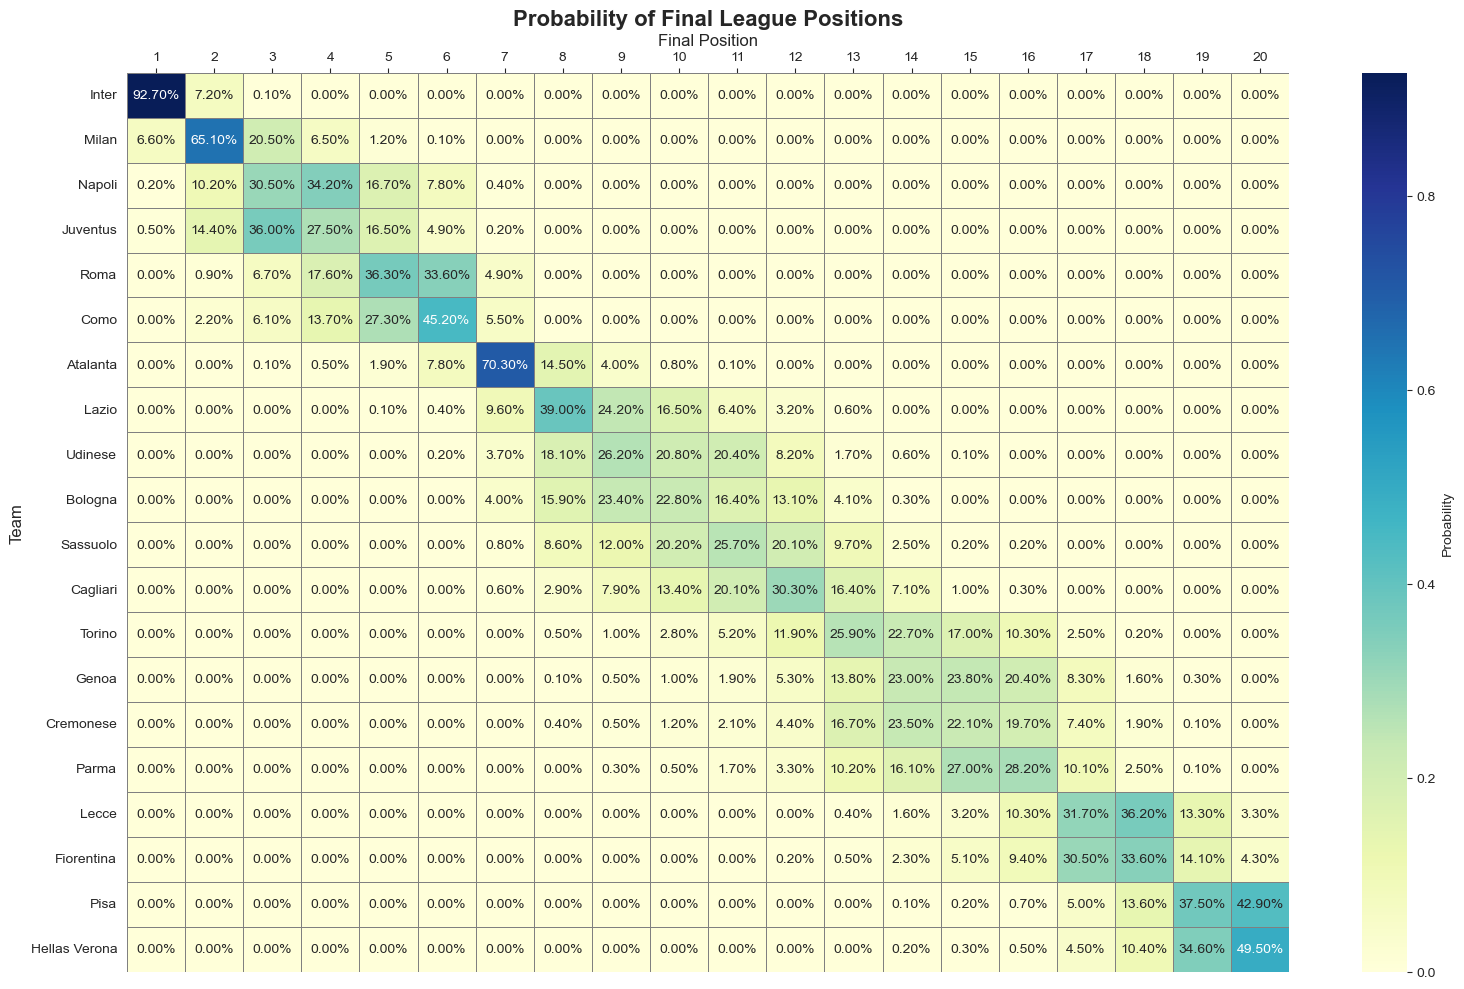

In [11]:
# Import visualization functions
from src.visualization import (
    plot_position_probabilities_heatmap,
    plot_team_position_distribution,
    plot_multiple_teams_distribution,
)

# Create heatmap visualization
plot_position_probabilities_heatmap(position_probs)

## 7. Detailed Team Analysis

Generate detailed statistics for each team's expected final position.

In [12]:
# Generate team statistics report
team_names = current_league_table["Team"].tolist()
team_stats_report = {}

for team in team_names:
    team_stats_report[team] = get_team_final_position_stats(position_probs, team)

# Create a DataFrame for better visualization
stats_df = pd.DataFrame(team_stats_report).T
stats_df = stats_df.sort_values("most_likely_position")

print("Team Final Position Statistics:\n")
print(stats_df)

Team Final Position Statistics:

               most_likely_position  most_likely_prob  mean_position  \
Inter                           1.0             0.927           1.07   
Milan                           2.0             0.651           2.31   
Juventus                        3.0             0.360           3.61   
Napoli                          4.0             0.342           3.82   
Roma                            5.0             0.363           5.10   
Como                            6.0             0.452           5.24   
Atalanta                        7.0             0.703           7.12   
Lazio                           8.0             0.390           8.82   
Bologna                         9.0             0.234           9.89   
Udinese                         9.0             0.262           9.70   
Sassuolo                       11.0             0.257          10.76   
Cagliari                       12.0             0.303          11.50   
Torino                         

## 8. Top Teams Analysis

Compare position distributions for top teams.

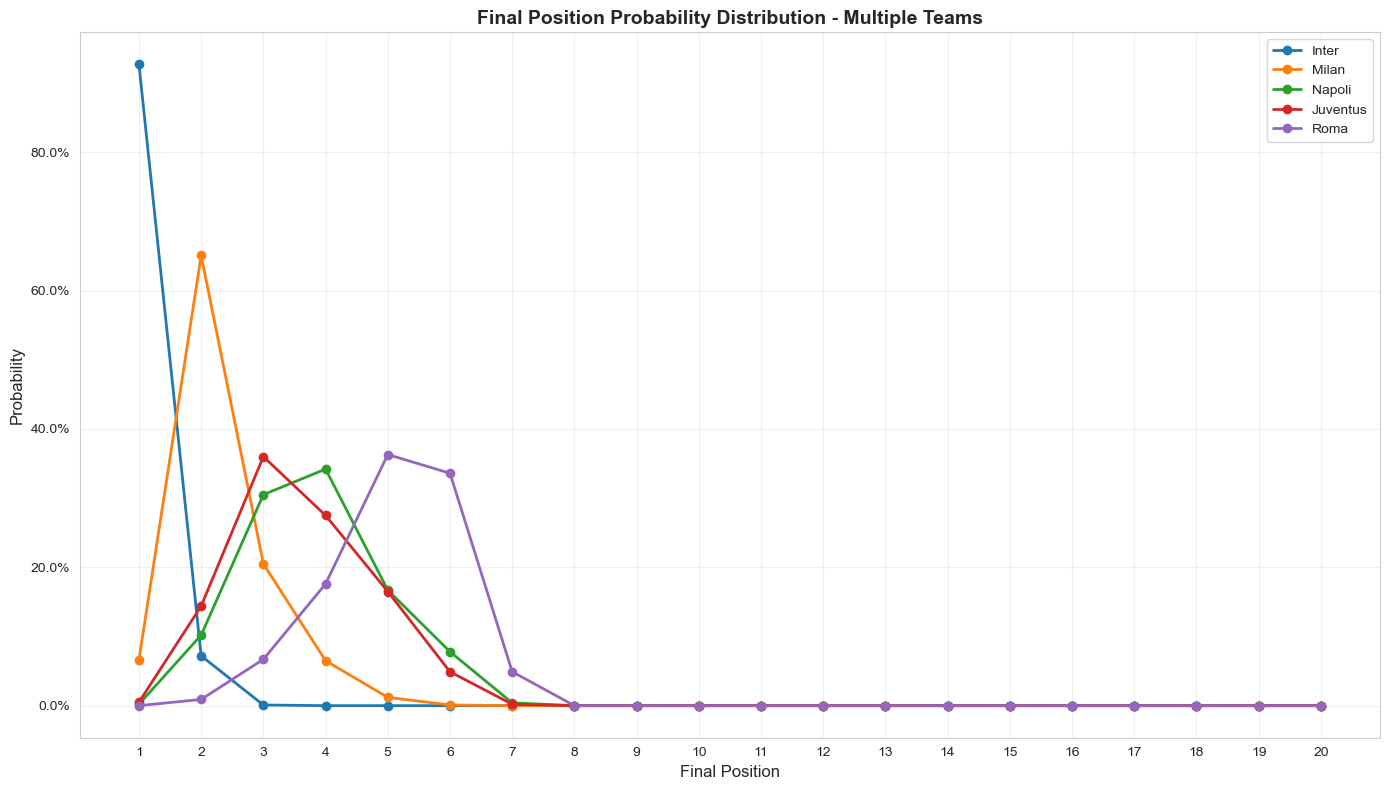

In [13]:
# Analyze top 5 teams
top_5_teams = current_league_table.head(5)["Team"].tolist()

plot_multiple_teams_distribution(position_probs, top_5_teams)

## 9. Summary and Conclusions

Key findings from the Monte Carlo simulation.

In [14]:
# Summary statistics
print(f"League: {config['league']['name']}")
print(f"Season: {config['league']['current_season']}")
print(f"Monte Carlo Simulations: {n_simulations}")
print()

print("Championship Probabilities (Top 3):")
for i, team in enumerate(stats_df.head(3).index, 1):
    prob = position_probs.loc[team, 1]
    print(f"{i}. {team}: {prob:.2%}")

print("\nRelegation Zone Probabilities (Bottom 3):")
n_positions = len(position_probs.columns)
for team in stats_df.tail(3).index:
    prob_bottom_3 = position_probs.loc[team, n_positions - 2 : n_positions].sum()
    print(f"{team}: {prob_bottom_3:.2%}")

League: Serie A
Season: 2025
Monte Carlo Simulations: 1000

Championship Probabilities (Top 3):
1. Inter: 92.70%
2. Milan: 6.60%
3. Juventus: 0.50%

Relegation Zone Probabilities (Bottom 3):
Fiorentina: 52.00%
Pisa: 94.00%
Hellas Verona: 94.50%
